In [ ]:
!pip install sentence_transformers
!pip install faiss-gpu
!pip install bm25s

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import ast
#import faiss
import torch
import os
import bm25s

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def get_embedding(model_name, text):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(text)
    return embeddings

In [ ]:
def get_fact_text(fact):
    fact_list = []
    for row in fact.itertuples(index=True, name='Pandas'):
        val = getattr(row, 'claim')
        tuple_data = ast.literal_eval(val)
        fact_list.append(tuple_data[1])
    return fact_list

In [ ]:
def get_post_text(post, col_name):
    post_text = []

    if col_name == 'ocr':
        for row in post.itertuples(index=True, name='Pandas'):
            val = getattr(row, col_name)
            q = ast.literal_eval(val)
            if not val or not q:
                post_text.append('')
            else:
                tup = q[0]
                post_text.append(tup[1])

    elif col_name == 'text':
        for row in post.itertuples(index=True, name='Pandas'):
            val = getattr(row, col_name)
            if not val:
                post_text.append('')
            else:
                #print(val)
                q = ast.literal_eval(val)
                post_text.append(q[1])
    return post_text

In [ ]:
def sep_empty(post, col_name):
    empty_num = 0
    sep_row = []
    for row in post.itertuples(index=True, name='Pandas'):
        val = getattr(row, col_name)
        if not val or val == '[]':
            empty_num += 1
        else:
            sep_row.append(row._asdict())

    sep_df = pd.DataFrame(sep_row)
    return sep_df

In [ ]:
def clean_Nan(post, col_name):
    post_cleaned = post.copy()
    post_cleaned[col_name] = post_cleaned[col_name].fillna("")

    return post_cleaned

In [ ]:
def get_embeddings_in_batches(model, texts, batch_size=512):
    """Generate embeddings for a list of texts using batch processing."""
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        with torch.cuda.amp.autocast(enabled=True):  # Mixed precision
            batch_embeddings = model.encode(batch_texts, convert_to_tensor=False, device=device)
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

In [ ]:
def build_faiss_index(embeddings):
    """Build a FAISS index for fast similarity search."""
    dimension = embeddings.shape[1]
    index = faiss.IndexFlatIP(dimension)  # Inner product (for cosine similarity)
    faiss.normalize_L2(embeddings)       # Normalize embeddings for cosine similarity
    index.add(embeddings)
    return index

In [ ]:
def search_faiss(index, query_embeddings, top_k=10):
    """Search FAISS index with query embeddings."""
    faiss.normalize_L2(query_embeddings)
    distances, indices = index.search(query_embeddings, top_k)
    return distances, indices

In [ ]:
def visualize_metrics(mrr, success_at_k, k_values):
    """
    Visualize MRR and Success@k as bar plots and line charts.

    Parameters:
        mrr (float): Mean Reciprocal Rank.
        success_at_k (dict): Dictionary with k values as keys and Success@k as values.
        k_values (list): List of k values used for evaluation.
    """
    import matplotlib.pyplot as plt

    # Bar plot for Success@k
    success_values = [success_at_k[k] for k in k_values]
    plt.figure(figsize=(10, 6))
    plt.bar([str(k) for k in k_values], success_values, color='skyblue')
    plt.title('Success@k for Different k Values')
    plt.xlabel('k')
    plt.ylabel('Success@k')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Line plot for MRR
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, success_values, marker='o', color='orange', label='Success@k')
    plt.axhline(y=mrr, color='green', linestyle='--', label=f'MRR: {mrr:.4f}')
    plt.title('MRR and Success@k Trends')
    plt.xlabel('k')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid(alpha=0.7)
    plt.show()


In [ ]:
def token_BM(corpus):
    corpus_tokens = bm25s.tokenize(corpus)
    return corpus_tokens

In [ ]:
def call_BM(post, fact, k_val):
    fact_tokens = token_BM(fact)
    post_tokens = token_BM(post)
    bm = bm25s.BM25()
    bm.index(fact_tokens)
    results, scores = bm.retrieve(post_tokens, k=k_val)
    return results, scores

In [ ]:
def compute_success_at_k(results_df, pairs, k):
    success_at_k = 0
    total_queries = 0
    for _, row in pairs.iterrows():
        correct_fact_id = row['fact_check_id']
        post_id = row['post_id']
        top_results = results_df[results_df['post_id'] == post_id].sort_values(by="similarity", ascending=False).head(k)

        if top_results.empty:
            continue

        ranks = list(top_results[top_results['fact_check_id'] == correct_fact_id].index)

        if correct_fact_id in top_results['fact_check_id'].values:
            success_at_k += 1
        #if ranks and ranks[0] + 1 <= k:
            #success_at_k += 1

        total_queries += 1
    print('success_at_k')
    print('total_queries')
    print(success_at_k)
    print(total_queries)
    print('done')
    return success_at_k / total_queries if total_queries else 0

def compute_precision_at_k(results_df, pairs, k):
    precision_at_k = 0
    total_queries = 0
    for _, row in pairs.iterrows():
        correct_fact_id = row['fact_check_id']
        post_id = row['post_id']
        top_results = results_df[results_df['post_id'] == post_id].sort_values(by="similarity", ascending=False).head(k)

        if top_results.empty:
            continue

        #ranks = list(top_results[top_results['fact_check_id'] == correct_fact_id].index)
        #if ranks and ranks[0] + 1 <= k:
            #precision_at_k += 1 / (ranks[0] + 1)

        # Count how many relevant results (matching fact_check_id) are in the top-k
        relevant_count = top_results['fact_check_id'].eq(correct_fact_id).sum()

        # Precision = relevant_count / k (if k results are available)
        precision_at_k = relevant_count / len(top_results)

        total_queries += 1
    print('precision_at_k')
    print('total_queries')
    print(precision_at_k)
    print(total_queries)
    print('done')
    return precision_at_k / total_queries if total_queries else 0

def compute_map(results_df, pairs, k):
    average_precision_sum = 0
    total_queries = 0
    for _, row in pairs.iterrows():
        correct_fact_id = row['fact_check_id']
        post_id = row['post_id']
        top_results = results_df[results_df['post_id'] == post_id].sort_values(by="similarity", ascending=False).head(k)

        if top_results.empty:
            continue

        ap = 0
        for idx, result in enumerate(top_results.itertuples(), start=1):
            if result.fact_check_id == correct_fact_id:
                ap += 1 / idx
        average_precision_sum += ap
        total_queries += 1
    print('map')
    print('total_queries')
    print(average_precision_sum)
    print(total_queries)
    print('done')
    return average_precision_sum / total_queries if total_queries else 0

def compute_mas(results_df, pairs, k):
    mas_scores = []
    total_queries = 0
    for _, row in pairs.iterrows():
        correct_fact_id = row['fact_check_id']
        post_id = row['post_id']
        top_results = results_df[results_df['post_id'] == post_id].sort_values(by="similarity", ascending=False).head(k)

        if top_results.empty:
            continue

        ranks = list(top_results[top_results['fact_check_id'] == correct_fact_id].index)
        if ranks:
            rank = ranks[0] + 1
            success_ratios = [1 if rank <= r else 0 for r in range(1, k + 1)]
            mas_scores.append(np.mean(success_ratios))

        total_queries += 1
    print('mas')
    print('total_queries')
    print(mas_scores)
    print(total_queries)
    print('done')
    return sum(mas_scores) / total_queries if mas_scores else 0

def compute_success_at_k_debug(results_df, pairs, k):
    success_at_k = 0
    total_queries = 0

    for _, row in pairs.iterrows():
        correct_fact_id = row['fact_check_id']
        post_id = row['post_id']

        # Get top-k results for this post_id
        top_results = results_df[results_df['post_id'] == post_id].sort_values(by="similarity", ascending=False).head(k)

        # Debugging: Print top results
        #print(f"Post ID: {post_id}, Correct Fact ID: {correct_fact_id}, Top-k Fact IDs: {top_results['fact_check_id'].tolist()}")

        if correct_fact_id in top_results['fact_check_id'].values:
            success_at_k += 1

        total_queries += 1

    success_rate = success_at_k / total_queries if total_queries > 0 else 0
    print(f"Intermediate Success@{k}: {success_rate:.4f}")

    print('success at k2')
    print('total_queries')
    print(success_at_k)
    print(total_queries)
    print('done')
    return success_rate
'''
    # Evaluate Metrics
print("Evaluating Metrics...")
success_rate = compute_success_at_k(results_df, pairs, k)
precision_at_k = compute_precision_at_k(results_df, pairs, k)
mean_average_precision = compute_map(results_df, pairs)
mean_average_success = compute_mas(results_df, pairs, k)
success_rate = compute_success_at_k_debug(results_df, pairs, k)

print(f"Success@{k}: {success_rate:.4f}")
print(f"Precision@{k}: {precision_at_k:.4f}")
print(f"Mean Average Precision (MAP): {mean_average_precision:.4f}")
print(f"Mean Average Success (MAS): {mean_average_success:.4f}")

    # Save results
return results_df, pairs
results_df.to_csv("faiss_results_full.csv", index=False)
print("Results saved to faiss_results_full.csv")
'''

'\n    # Evaluate Metrics\nprint("Evaluating Metrics...")\nsuccess_rate = compute_success_at_k(results_df, pairs, k)\nprecision_at_k = compute_precision_at_k(results_df, pairs, k)\nmean_average_precision = compute_map(results_df, pairs)\nmean_average_success = compute_mas(results_df, pairs, k)\nsuccess_rate = compute_success_at_k_debug(results_df, pairs, k)\n\nprint(f"Success@{k}: {success_rate:.4f}")\nprint(f"Precision@{k}: {precision_at_k:.4f}")\nprint(f"Mean Average Precision (MAP): {mean_average_precision:.4f}")\nprint(f"Mean Average Success (MAS): {mean_average_success:.4f}")\n\n    # Save results\nreturn results_df, pairs\nresults_df.to_csv("faiss_results_full.csv", index=False)\nprint("Results saved to faiss_results_full.csv")\n'

In [ ]:
def get_fact_text_k(fact, fact_id):
    fact_text = fact[fact['fact_check_id'] == fact_id]['claim'].values[0]
    return fact_text

def get_post_text_k(post, post_id):
    post_ocr = post[post['post_id'] == post_id]['ocr'].values[0]
    post_text = post[post['post_id'] == post_id]['text'].values[0]
    return [post_ocr, post_text]

def rank_true_k(post_id, pairs, true_pairs, fact):

    true_k_list = []
    filtered_pairs = true_pairs[true_pairs['post_id'] == post_id]
    k_pairs = pairs[pairs['post_id'] == post_id]
    #print('len kpair')
    #print(len(k_pairs))
    for index, row in filtered_pairs.iterrows():
        fact_id = row['fact_check_id']
        l_row = []
        row_text = get_fact_text_k(fact, fact_id)
        i = 0
        for index2, row2 in k_pairs.iterrows():
            i += 1
            if row2['fact_check_id'] == fact_id:
                l_row.append([(i-1), row_text, row2['similarity']])

        if not l_row:
            true_k_list.append(['not in k rank', row_text])

        else:
            true_k_list.extend(l_row)

    return true_k_list

def compare_top_k(fact, post, post_id, pairs, top_k, true_pairs):
    compare_list = []

    post_text = get_post_text_k(post, post_id)
    compare_list.append(post_text)


    filtered_pairs = pairs[pairs['post_id'] == post_id]['fact_check_id'].values
    filtered_sim_pairs = pairs[pairs['post_id'] == post_id]['similarity'].values

    top_k = min(len(filtered_pairs), top_k)
    #print(len(filtered_pairs))
    for i in range(top_k):
        correct_fact_id = filtered_pairs[i]
        fact_text = get_fact_text_k(fact, correct_fact_id)
        compare_list.append([(i), fact_text, filtered_sim_pairs[i]])

    true_k_rank = rank_true_k(post_id, pairs, true_pairs, fact)
    compare_list.extend(true_k_rank)

    return compare_list




Modified Pipeline with Success

In [ ]:
def pipeline2(posts_file, fact_checks_file, pairs_file, batch_size=512, model_name='sentence-transformers/all-MiniLM-L6-v2', use_ocr=True, use_txt=True, k_values=None):
    #model_name = 'sentence-transformers/distiluse-base-multilingual-cased-v1'

    if k_values is None:
        k_values = [1, 5, 10, 20, 50, 100, 1000]  # Default values for k

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    post = pd.read_csv(posts_file)
    fact = pd.read_csv(fact_checks_file)
    pairs = pd.read_csv(pairs_file)

    fact_list = get_fact_text(fact)
    combined = False
    if use_ocr and use_txt:
        clean_ocr = clean_Nan(post,'ocr')
        clean_text = clean_Nan(post,'text')

        ocr_list = get_post_text(clean_ocr,'ocr')
        text_list = get_post_text(clean_text,'text')

        post_list = [f"{a}{' ' if a and b else ''}{b}" for a, b in zip(ocr_list, text_list)]
        combined = True
        print('both')

    elif use_ocr:
        clean_ocr = clean_Nan(post,'ocr')
        sep_ocr = sep_empty(clean_ocr,'ocr')
        post_list = get_post_text(sep_ocr,'ocr')
        print('ocr')

    elif use_txt:
        clean_text = clean_Nan(post,'text')
        sep_text = sep_empty(clean_text,'text')
        post_list = get_post_text(sep_text,'text')
        print('text')
    #model_name = 'sentence-transformers/distiluse-base-multilingual-cased-v1'
    # Load model
    for k in k_values:
        model = SentenceTransformer(model_name, device=device)

        result, scores = call_BM(post_list, fact_list, k)
    #print(result[0])
    #print(scores[0])

        results_df = pd.DataFrame([
        {
            'post_id': post.iloc[i]['post_id'],
            'fact_check_id': fact.iloc[idx]['fact_check_id'],
            'similarity': dist
        }
        for i, (dists, idxs) in enumerate(zip(scores, result))
        for dist, idx in zip(dists, idxs)
    ])

    #print(results_df.shape)
    #print(results_df.head())

        print('success_k')
        success_k = compute_success_at_k(results_df, pairs, k)
        print('precision_k')
        precision_k = compute_precision_at_k(results_df, pairs, k)
        print('mean_average_precision')
        mean_average_precision = compute_map(results_df, pairs, k)
        print('mean_average_success')
        mean_average_success = compute_mas(results_df, pairs, k)

    #print('success_k2')
    #success_k2 = compute_success_at_k_debug(results_df, pairs, 100)
    #print(success_k2)

        print(f"Success@{k}: {success_k:.4f}")
        print(f"Precision@{k}: {precision_k:.4f}")
        print(f"Mean Average Precision (MAP): {mean_average_precision:.4f}")
        print(f"Mean Average Success (MAS): {mean_average_success:.4f}")

    #print(results.shape[1])
    #for i in range(results.shape[1]):
        #doc, score = results[0, i], scores[0, i]
        #print(f"Rank {i+1} (score: {score:.2f}): {doc}")

    # Save results
        results_df.to_csv("BM25_results.csv", index=False)
    return results_df
    #results_df.to_csv("faiss_results_full.csv", index=False)
    #print("Results saved to faiss_results_full.csv")


    '''
    results = []
    for i, (dists, idxs) in enumerate(zip(scores, result)):
        post_id = post.iloc[i]['post_id']
        for dist, idx in zip(dists, idxs):
            fact_check_id = fact.iloc[idx]['fact_check_id']
            results.append({'post_id': post_id, 'fact_check_id': fact_check_id, 'similarity': dist})
    results_df = pd.DataFrame(results)
    print(len(results_df))
    print(len(post))
    '''


In [ ]:
posts_file = 'drive/MyDrive/Sem_Sim_proj/posts.csv'
fact_checks_file = 'drive/MyDrive/Sem_Sim_proj/fact_checks.csv'
pairs_file = 'drive/MyDrive/Sem_Sim_proj/pairs.csv'
k_values = [5, 10, 20, 100]
x = pipeline2(posts_file, fact_checks_file, pairs_file, use_txt=True, use_ocr=True, k_values=k_values)


both


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Split strings:   0%|          | 0/153743 [00:00<?, ?it/s]

Split strings:   0%|          | 0/24431 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/24431 [00:00<?, ?it/s]

INFO:bm25s:The query is empty. This will result in a zero score for all documents.


success_k
success_at_k
total_queries
12924
25743
done
precision_k
precision_at_k
total_queries
0.2
25743
done
mean_average_precision
map
total_queries
9041.933333333127
25743
done
mean_average_success
mas
total_queries
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

Split strings:   0%|          | 0/153743 [00:00<?, ?it/s]

Split strings:   0%|          | 0/24431 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/24431 [00:00<?, ?it/s]

INFO:bm25s:The query is empty. This will result in a zero score for all documents.


success_k
success_at_k
total_queries
14837
25743
done
precision_k
precision_at_k
total_queries
0.1
25743
done
mean_average_precision
map
total_queries
9299.750793650734
25743
done
mean_average_success
mas
total_queries
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

Split strings:   0%|          | 0/153743 [00:00<?, ?it/s]

Split strings:   0%|          | 0/24431 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/24431 [00:00<?, ?it/s]

INFO:bm25s:The query is empty. This will result in a zero score for all documents.


success_k
success_at_k
total_queries
16305
25743
done
precision_k
precision_at_k
total_queries
0.05
25743
done
mean_average_precision
map
total_queries
9402.920690596775
25743
done
mean_average_success
mas
total_queries
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

Split strings:   0%|          | 0/153743 [00:00<?, ?it/s]

Split strings:   0%|          | 0/24431 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/24431 [00:00<?, ?it/s]

INFO:bm25s:The query is empty. This will result in a zero score for all documents.


success_k
success_at_k
total_queries
18752
25743
done
precision_k
precision_at_k
total_queries
0.01
25743
done
mean_average_precision
map
total_queries
9464.463122645462
25743
done
mean_average_success
mas
total_queries
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
posts_file = 'drive/MyDrive/Sem_Sim_proj/posts.csv'
fact_checks_file = 'drive/MyDrive/Sem_Sim_proj/fact_checks.csv'
pairs_file = 'drive/MyDrive/Sem_Sim_proj/pairs.csv'
k_values = [50, 100]
x = pipeline2(posts_file, fact_checks_file, pairs_file, use_txt=True, use_ocr=True, k_values=k_values)

both


Split strings:   0%|          | 0/153743 [00:00<?, ?it/s]

Split strings:   0%|          | 0/24431 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/24431 [00:00<?, ?it/s]

INFO:bm25s:The query is empty. This will result in a zero score for all documents.


success_k
success_at_k
total_queries
17787
25743
done
precision_k
precision_at_k
total_queries
0.02
25743
done
mean_average_precision
map
total_queries
9453.350215538034
25743
done
mean_average_success
mas
total_queries
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

Split strings:   0%|          | 0/153743 [00:00<?, ?it/s]

Split strings:   0%|          | 0/24431 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/24431 [00:00<?, ?it/s]

INFO:bm25s:The query is empty. This will result in a zero score for all documents.


success_k
success_at_k
total_queries
18752
25743
done
precision_k
precision_at_k
total_queries
0.01
25743
done
mean_average_precision
map
total_queries
9466.480666199477
25743
done
mean_average_success
mas
total_queries
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
posts_file = 'drive/MyDrive/Sem_Sim_proj/posts.csv'
fact_checks_file = 'drive/MyDrive/Sem_Sim_proj/fact_checks.csv'
pairs_file = 'drive/MyDrive/Sem_Sim_proj/pairs.csv'
k_values = [100]
x = pipeline2(posts_file, fact_checks_file, pairs_file, use_txt=True, use_ocr=True, k_values=k_values)

both


Split strings:   0%|          | 0/153743 [00:00<?, ?it/s]

Split strings:   0%|          | 0/24431 [00:00<?, ?it/s]

DEBUG:bm25s:Building index from IDs objects


BM25S Count Tokens:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Compute Scores:   0%|          | 0/153743 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/24431 [00:00<?, ?it/s]

INFO:bm25s:The query is empty. This will result in a zero score for all documents.


success_k
success_at_k
total_queries
18752
25743
done
precision_k
precision_at_k
total_queries
0.01
25743
done
mean_average_precision
map
total_queries
9466.480666199477
25743
done
mean_average_success
mas
total_queries
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [ ]:
post = pd.read_csv(posts_file)
fact = pd.read_csv(fact_checks_file)
pairs = pd.read_csv(pairs_file)
x_list = compare_top_k(fact, post, 2228, x, 10, pairs)

100


In [ ]:
print(len(x_list))
for ix in x_list:
    print(ix)

14
["[('WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHEN A YEAR AGO WE HAD THE LOWEST UNEMPLOYMENT IN HISTORY WITHOUT USING TAXPAYERS MONEY?', 'WHY DO WE NEED A $4 TRILLION JOBS PLAN, WHEN A YEAR AGO WE HAD THE LOWEST UNEMPLOYMENT IN HISTORY WITHOUT USING TAXPAYERS MONEY?', [('eng', 1.0)])]", nan]
[0, "('“A year ago we had the lowest unemployment in history without using taxpayers money.”', '“A year ago we had the lowest unemployment in history without using taxpayers money.”', [('eng', 1.0)])", 24.80106]
[1, '(\'"$4 trillion jobs plan" unnecessary because 2020 unemployment was lowest ever without it\', \'"$4 trillion jobs plan" unnecessary because 2020 unemployment was lowest ever without it\', [(\'eng\', 1.0)])', 14.744118]
[2, "('America had the lowest unemployment rate in history a year ago in April 2020', 'America had the lowest unemployment rate in history a year ago in April 2020', [('eng', 1.0)])", 13.523425]
[3, '("April 2020 was the lowest unemployment rate in American history, w

In [ ]:
post = pd.read_csv(posts_file)
fact = pd.read_csv(fact_checks_file)
pairs = pd.read_csv(pairs_file)
x_list = compare_top_k(fact, post, 381, x, 10, pairs)
print(len(x_list))
for ix in x_list:
    print(ix)

100
15
["[('ABSENT from the News Dominion LOST their law suits against Rudy Giuliani and Sidney Powell', 'ABSENT from the News Dominion LOST their law suits against Rudy Giuliani and Sidney Powell', [('eng', 1.0)])]", nan]
[0, '(\'"Dominion LOST their law suits against Rudy Giuliani and Sidney Powell."\', \'"Dominion LOST their law suits against Rudy Giuliani and Sidney Powell."\', [(\'eng\', 1.0)])', 28.013506]
[1, '(\'"Absent from the news — Dominion lost their lawsuits against Rudy Giuliani and Sidney Powell."\', \'"Absent from the news — Dominion lost their lawsuits against Rudy Giuliani and Sidney Powell."\', [(\'eng\', 1.0)])', 26.73733]
[2, "('Dominion LOST their lawsuits against Rudy Giuliani and Sidney Powell', 'Dominion LOST their lawsuits against Rudy Giuliani and Sidney Powell', [('eng', 1.0)])", 23.193924]
[3, "('Dominion lost lawsuits against Rudy Giuliani and Sidney Powell', 'Dominion lost lawsuits against Rudy Giuliani and Sidney Powell', [('eng', 1.0)])", 23.193924]
[4

In [ ]:
x_list = compare_top_k(fact, post, 5551, x, 10, pairs)
print(len(x_list))
for ix in x_list:
    print(ix)

x_list = compare_top_k(fact, post, 1222, x, 10, pairs)
print(len(x_list))
for ix in x_list:
    print(ix)

x_list = compare_top_k(fact, post, 1274, x, 10, pairs)
print(len(x_list))
for ix in x_list:
    print(ix)

x_list = compare_top_k(fact, post, 1275, x, 10, pairs)
print(len(x_list))
for ix in x_list:
    print(ix)

x_list = compare_top_k(fact, post, 481, x, 10, pairs)
print(len(x_list))
for ix in x_list:
    print(ix)

x_list = compare_top_k(fact, post, 12958, x, 10, pairs)
print(len(x_list))
for ix in x_list:
    print(ix)

x_list = compare_top_k(fact, post, 22409, x, 10, pairs)
print(len(x_list))
for ix in x_list:
    print(ix)

x_list = compare_top_k(fact, post, 9945, x, 10, pairs)
print(len(x_list))
for ix in x_list:
    print(ix)



100
12
['[("JOKOWI DIKATAKAN SEPERTI ANAK KECIL DAN BODOH OLEH MEDIA LUAR respondente ASIAN \'Disappointed\': the stupid president of Indonesia jokowi upset like a child That saudi invest in china more than indonesia. Pinis zate [USER].id INDONESIA KEHILANGAN KEHORMATAN?", "JOKOWI SAYS LIKE LITTLE AND STUPID CHILDREN BY OUTSIDE MEDIA respondent ASIAN \'Disappointed\': the stupid president of Indonesia jokowi upset like a child That saudi invest in china more than indonesia. Pinis zate [USER].id INDONESIA IS LOSSING HONOR?", [(\'eng\', 0.5054696798324585), (\'msa\', 0.3229984641075134), (\'msa\', 0.06089252606034279), (\'af\', 0.034851234406232834)])]', '("Aiikkk Media luar baru tau yaa... Kami rakyat Indonesia sdh tau lama kalau dia dan pengikutnya sama2 bodoh... Hanya media kafir Indonesia aja yg mengatakan dia ni bijak pandai ... Yang bukan merasa rakyat jokowi mari lah kita tertawa berjama\'ah🤣🤣🤣🤣🤣😛 #tolakjokowi", "Aiikkk The outside media just found out... We Indonesian people have

In [ ]:
unique_post_ids_list = pairs['post_id'].unique().tolist()
for iix in unique_post_ids_list:
    x_list = compare_top_k(fact, post, iix, x, 10, pairs)
    print(len(x_list))
    for ix in x_list:
        print(ix)


Streaming output truncated to the last 5000 lines.
[9, "('Cette citation et cette photo de Lionel Messi sont vraies', 'This quote and photo of Lionel Messi is true', [('fra', 1.0)])", 7.3949165]
[0, "('ميسي موجود حاليا في طنجة المغرب', 'Messi is currently in Tangiers, Morocco', [('ara', 1.0)])", 23.980318069458008]
100
12
['[]', '(\'باراك اوباما يذكر اسم زوجته مايكل بدلاً من ميشيل في خطبة رسميةً ؟! كان من اكبر المناصرين للشواذ والمتحولين جنسياً ... ربما زوجته كانت دكر قبل أن تتحول الي انثي .... شيء غريب فعلاً ... معظم تكوين عظام جسم ميشيل اوباما تدل علي انها رجل ..حتى اليدين لا تدل ابدا علي انها امرأة ... الفيديو في اللينك أدناه : [URL] [URL]\', "Barack Obama mentions his wife Michael\'s name instead of Michelle in an official engagement?! He was one of the biggest advocates of gays and transgender people... Maybe his wife was a male before she turned into a female... Something really strange... Most of the composition of the bones of Michelle Obama\'s body indicate that she is a man..

In [ ]:
unique_post_ids_list = pairs['post_id'].unique().tolist()
with open('output2.txt', 'w') as f:
    for iix in unique_post_ids_list:
        x_list = compare_top_k(fact, post, iix, x, 10, pairs)
        f.write(str(len(x_list)))
        f.write("\n")
        for ix in x_list:
            f.write(str(ix))
            f.write("\n")
        f.write("\n")
        f.write("\n")

In [ ]:
!pip install sentence_transformers
!pip install faiss-gpu
!pip install bm25s

ERROR: Could not find a version that satisfies the requirement faiss-gpu (from versions: none)
ERROR: No matching distribution found for faiss-gpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import ast
#import faiss
import torch
import os
import bm25s
import math

In [ ]:
# prompt: given a df with column name col create a histogram of the entries in the column

import matplotlib.pyplot as plt

def create_histogram(df, column_name):
    """
    Creates a histogram of the entries in the specified column of a DataFrame.

    Args:
      df: The input Pandas DataFrame.
      column_name: The name of the column to create the histogram from.
    """
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.hist(df[column_name], bins=20, edgecolor='black')  # Adjust number of bins
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column_name}')
    plt.grid(True)
    plt.show()

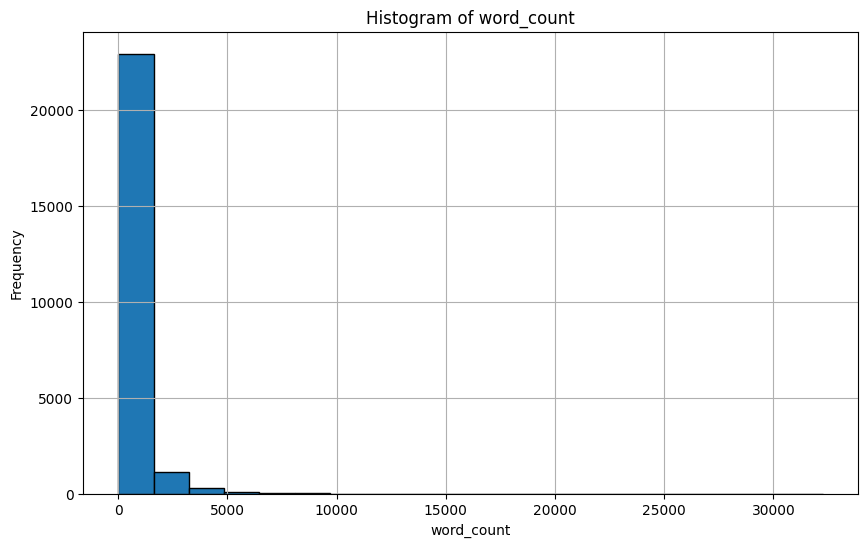

In [ ]:
counts = pd.read_csv('drive/MyDrive/Sem_Sim_proj/post_word_count.csv')
create_histogram(counts, 'word_count')

In [ ]:
# prompt: given df with a column name col acquire all of the most important ranges and print it

import pandas as pd

def get_important_ranges(df, column_name):
    """
    Acquires important ranges (min, max, quartiles, mean, median) from a DataFrame column.

    Args:
        df: The input DataFrame.
        column_name: The name of the column.

    Returns:
        A dictionary containing the important ranges.
    """

    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return None

    description = df[column_name].describe()
    important_ranges = {
        "min": description['min'],
        "max": description['max'],
        "25%": description['25%'],
        "50%": description['50%'],
        "75%": description['75%'],
        "mean": description['mean'],
        "std": description['std']
    }
    return important_ranges

# Assuming 'x' is your DataFrame (from previous code) and 'col' is your column name
# Example usage:
important_ranges = get_important_ranges(counts, 'word_count')
print(important_ranges)

{'min': 5.0, 'max': 32266.0, '25%': 143.0, '50%': 270.0, '75%': 534.0, 'mean': 506.56980884941265, 'std': 800.495181803428}


[((5.0, 82.0), 2439), ((82.0, 122.0), 2418), ((122.0, 165.0), 2459), ((165.0, 215.0), 2455), ((215.0, 270.0), 2424), ((270.0, 344.0), 2452), ((344.0, 454.0), 2445), ((454.0, 647.0), 2450), ((647.0, 1135.0), 2445), ((1135.0, 32266.0), 2443)]

Significant ranges (frequency >= 5): [((5.0, 82.0), 2439), ((82.0, 122.0), 2418), ((122.0, 165.0), 2459), ((165.0, 215.0), 2455), ((215.0, 270.0), 2424), ((270.0, 344.0), 2452), ((344.0, 454.0), 2445), ((454.0, 647.0), 2450), ((647.0, 1135.0), 2445), ((1135.0, 32266.0), 2443)]


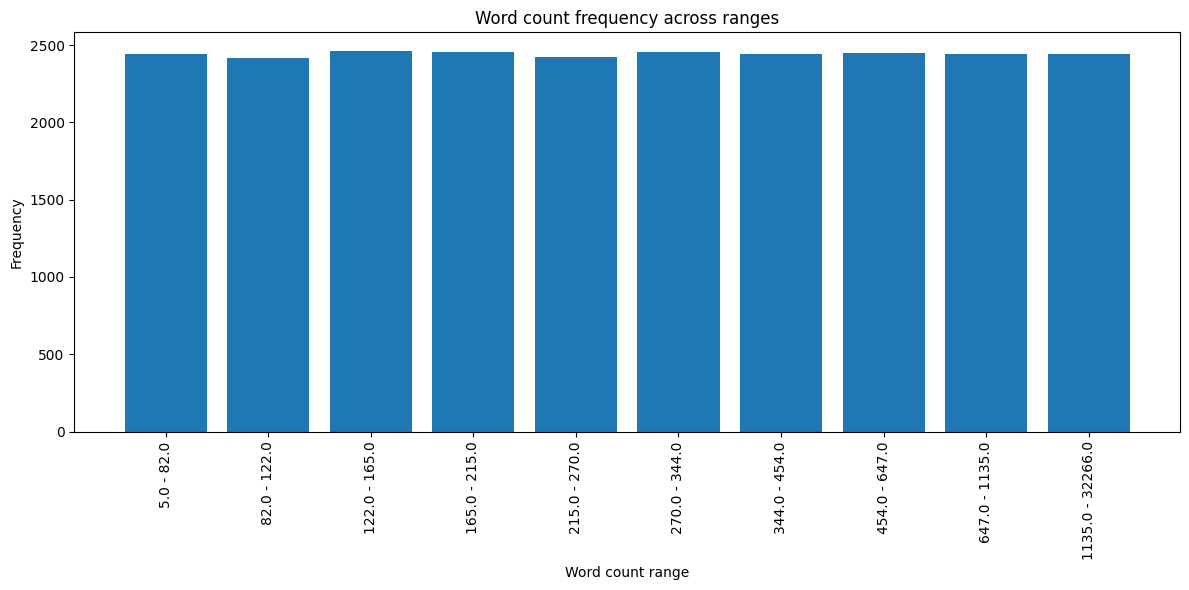

In [ ]:
# prompt: there is a large list of numbers how do I determine the largest amount of discrete ranges that have a significant portion of entries in them and how many ranges there should be

import pandas as pd
import numpy as np

def get_important_ranges(df, column_name, num_ranges=5):
    """
    Identifies significant ranges within a dataset column, aiming for a specified number of ranges.

    Args:
        df: The input DataFrame.
        column_name: The name of the column to analyze.
        num_ranges: The desired number of ranges (default is 5).

    Returns:
        A list of tuples, where each tuple represents a range (start, end) and its frequency.
    """

    if column_name not in df.columns:
        print(f"Error: Column '{column_name}' not found in DataFrame.")
        return None

    # Calculate quantiles to define potential range boundaries
    quantiles = np.linspace(0, 1, num_ranges + 1)  # Adjust number of quantiles
    boundaries = df[column_name].quantile(quantiles)

    ranges = []
    for i in range(num_ranges):
        start = boundaries.iloc[i]
        end = boundaries.iloc[i + 1]

        # Count the number of values in the current range
        frequency = len(df[(df[column_name] >= start) & (df[column_name] < end)])
        ranges.append(((start, end), frequency))

    return ranges

# Example usage:
counts = pd.read_csv('drive/MyDrive/Sem_Sim_proj/post_word_count.csv')
ranges = get_important_ranges(counts, 'word_count', num_ranges=10)
print(ranges)

# Further analysis:

# Filter ranges based on minimum frequency (optional)
min_frequency_threshold = 5  # Set threshold to your criteria
significant_ranges = [r for r in ranges if r[1] >= min_frequency_threshold]
print("\nSignificant ranges (frequency >= {}):".format(min_frequency_threshold), significant_ranges)

# Plot frequency vs range
import matplotlib.pyplot as plt

start_ends = [r[0] for r in ranges]
frequencies = [r[1] for r in ranges]

plt.figure(figsize=(12,6))
plt.bar([f"{x[0]} - {x[1]}" for x in start_ends], frequencies)
plt.xlabel("Word count range")
plt.ylabel("Frequency")
plt.title("Word count frequency across ranges")
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.tight_layout() # Adjust the layout
plt.show()

In [ ]:
print(len(counts))

24431


In [ ]:
counts = pd.read_csv('drive/MyDrive/Sem_Sim_proj/post_word_count.csv')

In [ ]:
count_dict = dict()
for row in ranges:
    row_list = []
    lower = math.ceil(row[0][0])
    upper = math.ceil(row[0][1])
    sub = counts[(counts['word_count'] >= lower) & (counts['word_count'] < upper)]
    row_list = sub['post_id'].values
    range_title = f"{lower}-{upper}"
    count_dict[range_title] = row_list.tolist()



In [ ]:
print(count_dict)

{'5-36': [224, 466, 525, 551, 554, 560, 961, 972, 1017, 1252, 1364, 1423, 1447, 1809, 2031, 2049, 2050, 2426, 2949, 3095, 3532, 3556, 3955, 4401, 4490, 4518, 4724, 4906, 4992, 5077, 5236, 5514, 5525, 5649, 5767, 5927, 6016, 6104, 6116, 6141, 6164, 6265, 6295, 6312, 6340, 6347, 6422, 6600, 6618, 6627, 6661, 6681, 6710, 6712, 6792, 6809, 6810, 6881, 6995, 7041, 7045, 7069, 7310, 7419, 7585, 7608, 7690, 7715, 7739, 7860, 7861, 7876, 7880, 8025, 8267, 8331, 8336, 8398, 8411, 8557, 8678, 8825, 8864, 9042, 9056, 9194, 9196, 9356, 9361, 9365, 9424, 9443, 9452, 9517, 9527, 9567, 9595, 9767, 9865, 9915, 10033, 10097, 10153, 10164, 10286, 10502, 10508, 10531, 10547, 10548, 10572, 10683, 10740, 10774, 10877, 10928, 10950, 11003, 11162, 11171, 11479, 11483, 11503, 11563, 11706, 11805, 11891, 12049, 12079, 12145, 12148, 12229, 12319, 12341, 12434, 12443, 12451, 12452, 12524, 12570, 12594, 12820, 12867, 12962, 12976, 13009, 13093, 13115, 13179, 13337, 13463, 13467, 13493, 13565, 13581, 13662, 13706,

In [ ]:
count_cat = pd.DataFrame()

for key in count_dict:
    count_cat[key] = [count_dict[key]]
count_cat.to_csv('count_cat_10.csv')

In [ ]:
def get_lang(post, col_name):
    post_lang = []
    post_id = []
    for row in post.itertuples(index=True, name='Pandas'):
        flag = False
        for col in col_name:
            if flag:
                break
            if col == 'ocr':
                val = getattr(row, col)
                q = ast.literal_eval(val)
                if not val or not q:
                    x = 1
                else:
                    tup = q[0]
                    q2 = tup[2]
                    q3 = q2[0]
                    q4 = q3[0]
                    post_lang.append(q4)
                    post_id.append(getattr(row, 'post_id'))
                    flag = True
                    break

            elif col == 'text':
                val = getattr(row, col)
                if not val:
                    x = 1
                else:
                    q = ast.literal_eval(val)
                    q2 = q[2]
                    q3 = q2[0]
                    q4 = q3[0]
                    post_lang.append(q4)
                    post_id.append(getattr(row, 'post_id'))
                    flag = True
                    break

    return post_lang , post_id

In [ ]:
testing_post = pd.read_csv('drive/MyDrive/Sem_Sim_proj/posts.csv')
col_list = ['ocr','text']
x = testing_post.head(1)

k, i = get_lang(testing_post, col_list)


In [ ]:
print(len(k))
print(len(i))
print(len(testing_post))

24431
24431
24431


In [ ]:
df = pd.DataFrame({'post_id': i, 'Language': k})
df.to_csv('post_lang.csv')

In [ ]:
def get_source(post):
    post_source = []
    post_id = []
    for row in post.itertuples(index=True, name='Pandas'):
        post_id.append(getattr(row, 'post_id'))
        val = getattr(row, 'instances')
        tup = ast.literal_eval(val)
        q = tup[0]
        q2 = q[1]
        post_source.append(q2)
    return post_source, post_id

In [ ]:
s, index = get_source(testing_post)
df2 = pd.DataFrame({'post_id': index, 'Source': s})
df2.to_csv('post_source.csv')

In [ ]:
source_dict = dict()
source_cats = ['ig','tw','fb']
for cat in source_cats:
    row_list = []
    sub = df2[(df2['Source'] == cat)]
    row_list = sub['post_id'].values
    source_dict[cat] = [row_list.tolist()]



In [ ]:
print(source_dict)

{'ig': [3, 17, 18, 28, 47, 55, 89, 100, 162, 318, 330, 391, 397, 417, 436, 467, 483, 529, 536, 557, 559, 594, 595, 599, 613, 633, 655, 684, 689, 696, 744, 777, 795, 838, 858, 879, 884, 890, 900, 906, 922, 935, 940, 1025, 1044, 1047, 1049, 1069, 1097, 1113, 1119, 1130, 1131, 1158, 1166, 1168, 1191, 1268, 1289, 1311, 1379, 1380, 1394, 1396, 1408, 1411, 1414, 1423, 1444, 1480, 1488, 1501, 1502, 1505, 1524, 1552, 1557, 1564, 1567, 1574, 1575, 1594, 1645, 1662, 1676, 1692, 1699, 1706, 1718, 1740, 1745, 1749, 1771, 1777, 1811, 1826, 1830, 1837, 1847, 1860, 1861, 1886, 1958, 1967, 2028, 2083, 2099, 2118, 2125, 2171, 2198, 2241, 2283, 2284, 2285, 2293, 2305, 2313, 2325, 2330, 2333, 2337, 2339, 2342, 2350, 2352, 2353, 2365, 2377, 2381, 2383, 2385, 2387, 2391, 2395, 2398, 2401, 2404, 2406, 2407, 2410, 2412, 2413, 2418, 2422, 2424, 2428, 2429, 2445, 2465, 2470, 2514, 2521, 2529, 2533, 2628, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2755, 2756, 2831, 2855, 2886, 2898, 2906, 2924, 2925, 2977, 2986,

In [ ]:
source_cat_df = pd.DataFrame(source_dict)
source_cat_df.to_csv('source_cat.csv')

In [ ]:
lang_dict = dict()
lang_cats = ['eng','spa','fra', 'deu', 'por', 'ara', 'msa', 'tha']
for cat in lang_cats:
    row_list = []
    sub = df[(df['Language'] == cat)]
    row_list = sub['post_id'].values
    lang_dict[cat] = [row_list.tolist()]

In [ ]:
print(lang_dict)

{'eng': [[1, 2, 5, 13, 14, 15, 19, 20, 36, 44, 46, 47, 51, 53, 54, 62, 78, 80, 93, 94, 104, 105, 109, 110, 112, 117, 119, 122, 125, 128, 129, 133, 134, 135, 137, 139, 140, 143, 155, 164, 165, 166, 169, 181, 183, 185, 188, 198, 210, 217, 219, 222, 223, 229, 231, 236, 242, 246, 259, 267, 271, 273, 276, 279, 284, 286, 294, 295, 297, 302, 303, 304, 309, 311, 313, 314, 316, 319, 320, 323, 331, 332, 333, 336, 353, 354, 360, 364, 366, 369, 372, 373, 376, 378, 381, 389, 390, 405, 406, 413, 421, 422, 430, 433, 435, 436, 466, 467, 468, 469, 471, 478, 486, 488, 503, 507, 508, 509, 510, 511, 512, 513, 515, 522, 525, 526, 527, 528, 529, 530, 532, 540, 541, 542, 543, 544, 547, 548, 549, 551, 553, 554, 560, 562, 563, 564, 567, 568, 569, 576, 578, 586, 588, 597, 599, 600, 608, 617, 619, 625, 628, 635, 643, 655, 656, 664, 665, 666, 669, 670, 674, 680, 698, 699, 700, 702, 715, 717, 722, 729, 730, 731, 732, 739, 740, 741, 742, 744, 745, 747, 750, 751, 752, 754, 755, 758, 768, 770, 771, 772, 776, 777, 780

In [ ]:
lang_cat_df = pd.DataFrame(lang_dict)
lang_cat_df.to_csv('lang_cat.csv')

In [ ]:
import json

df_results = pd.read_csv('drive/MyDrive/Sem_Sim_proj/BM25_results.csv')

with open("drive/MyDrive/Sem_Sim_proj/monolingual_predictions.json", "r") as file:
    i_mono = json.load(file)

with open("drive/MyDrive/Sem_Sim_proj/crosslingual_predictions.json", "r") as file:
    i_cross = json.load(file)

mono_id = list(i_mono.keys())
cross_id = list(i_cross.keys())

mono_dict = dict()
cross_dict = dict()


for id in mono_id:
    sub_df = df_results[df_results['post_id'] == int(id)]
    top_10_rows = sub_df.nlargest(10, 'similarity')
    mono_dict[id] = top_10_rows['fact_check_id'].tolist()

for id in cross_id:
    sub_df = df_results[df_results['post_id'] == int(id)]
    top_10_rows = sub_df.nlargest(10, 'similarity')
    cross_dict[id] = top_10_rows['fact_check_id'].tolist()





In [ ]:
with open("monolingual_predictions.json", "w") as json_file:
    json.dump(mono_dict, json_file)

with open("crosslingual_predictions.json", "w") as json_file:
    json.dump(cross_dict, json_file)

In [ ]:
print(mono_dict)

{'1': [102238, 101553, 101551, 102065, 101550, 17480, 106943, 6940, 118819, 107061], '48': [62464, 28173, 200553, 98619, 62467, 62466, 38003, 137947, 62475, 4687], '61': [25523, 25527, 25518, 195571, 119737, 195581, 1802, 6534, 200984, 149138], '122': [4034, 33790, 84323, 84324, 962, 125514, 79914, 79915, 131003, 126095], '124': [82699, 152456, 57608, 99796, 131476, 2556, 10024, 152198, 39411, 87838], '125': [49178, 47972, 40117, 49179, 40118, 103296, 193256, 47973, 48837, 64860], '128': [127038, 41582, 41584, 154682, 79863, 112859, 199717, 41583, 79864, 84608], '149': [39355, 51323, 171885, 146847, 12830, 50905, 12239, 58472, 126192, 176614], '158': [155800, 155840, 35349, 26286, 47585, 202229, 147140, 78804, 64628, 71210], '216': [73852, 91470, 1713, 81020, 102422, 201167, 201168, 102423, 53547, 90635], '229': [139102, 131003, 89635, 9550, 9551, 37293, 100640, 131948, 69848, 169742], '245': [29952, 101750, 108215, 125815, 196738, 30518, 200854, 172271, 139061, 154205], '268': [40390,